In [1]:
import torch
import torch.utils.data
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms


import ignite
from ignite.engine import Events, Engine
from ignite.metrics import Accuracy, Loss

import numpy as np
import sklearn.datasets
from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## MODEL

In [2]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(2 * 2 * 128, 256)

    def compute_features(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2, 2)

        x = x.flatten(1)

        x = F.relu(self.fc1(x))

        return x


class CNN_DUQ(Model):
    def __init__(
        self,
        input_size,
        num_classes,
        embedding_size,
        learnable_length_scale,
        length_scale,
        gamma,
    ):
        super().__init__()

        self.gamma = gamma

        self.W = nn.Parameter(
            torch.normal(torch.zeros(embedding_size, num_classes, 256), 0.05)
        )

        self.register_buffer("N", torch.ones(num_classes) * 12)
        self.register_buffer(
            "m", torch.normal(torch.zeros(embedding_size, num_classes), 1)
        )

        self.m = self.m * self.N.unsqueeze(0)

        if learnable_length_scale:
            self.sigma = nn.Parameter(torch.zeros(num_classes) + length_scale)
        else:
            self.sigma = length_scale

    def update_embeddings(self, x, y):
        z = self.last_layer(self.compute_features(x))

        # normalizing value per class, assumes y is one_hot encoded
        self.N = self.gamma * self.N + (1 - self.gamma) * y.sum(0)

        # compute sum of embeddings on class by class basis
        features_sum = torch.einsum("ijk,ik->jk", z, y)

        self.m = self.gamma * self.m + (1 - self.gamma) * features_sum

    def last_layer(self, z):
        z = torch.einsum("ij,mnj->imn", z, self.W)
        return z

    def output_layer(self, z):
        embeddings = self.m / self.N.unsqueeze(0)

        diff = z - embeddings.unsqueeze(0)
        distances = (-(diff ** 2)).mean(1).div(2 * self.sigma ** 2).exp()

        return distances

    def forward(self, x):
        z = self.last_layer(self.compute_features(x))
        y_pred = self.output_layer(z)

        return z, y_pred

In [3]:
input_size = 28
num_classes = 10
embedding_size = 256
learnable_length_scale = False
gamma = 0.999
# length_scales = [0.05, 0.1, 0.2, 0.3, 0.5, 1.0]
length_scale = 0.3

model = CNN_DUQ(
    input_size,
    num_classes,
    embedding_size,
    learnable_length_scale,
    length_scale,
    gamma,
)

optimizer = torch.optim.SGD(
    model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4
)

## Dataset

In [4]:
transform = torchvision.transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST("./", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST("./", download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, num_workers=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, num_workers=4, shuffle=False)

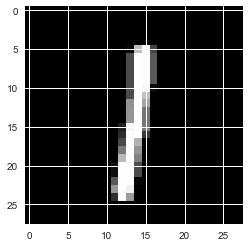

In [6]:
dataloader_iterator = iter(train_loader)
x, y = next(dataloader_iterator)
y = F.one_hot(y, num_classes=10).float()
y[0]
img = x[2].view(28, 28).data

plt.figure()
plt.imshow(img, cmap='gray')
plt.show()   
# type(x[0].shape)
# print(x[0])
a = model(x)
# a ** 2
# x torch.Size([128, 1, 28, 28])
# z torch.Size([128, 256, 10])
# DIFF torch.Size([128, 256, 10])

### LOSS

In [7]:
def calc_gradient_penalty(x, y_pred_sum):
    gradients = torch.autograd.grad(
        outputs=y_pred_sum,
        inputs=x,
        grad_outputs=torch.ones_like(y_pred_sum),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradients = gradients.flatten(start_dim=1)

    # L2 norm
    grad_norm = gradients.norm(2, dim=1)

    # Two sided penalty
    gradient_penalty = ((grad_norm - 1) ** 2).mean()

    return gradient_penalty

## Traning 

In [8]:
def eval():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      z, output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
#   test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))



epochs = 30
l_gradient_penalty = 0.05

for epoch in range(epochs):
    loss = 0
    bce = 0
    GP = 0
    for i, batch in enumerate(train_loader):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        model.train()
        optimizer.zero_grad()

        x, y = batch
        y = F.one_hot(y, num_classes=10).float()

        x, y = x.to(device), y.to(device)

        x.requires_grad_(True)

        z, y_pred = model(x)
        bce_loss = F.binary_cross_entropy(y_pred, y)
        GP_loss = l_gradient_penalty * calc_gradient_penalty(x, y_pred.sum(1))
        train_loss = bce_loss + GP_loss
        x.requires_grad_(False)

        train_loss.backward()
        optimizer.step()
        with torch.no_grad():
            model.eval()
            model.update_embeddings(x, y)   
        loss += train_loss.item()
        bce += bce_loss.item()
        GP += GP_loss.item()
        print("iteration : {}/{} LOSS : {}".format(i, len(train_loader), train_loss.item()))
    loss = loss/len(train_loader)
    bce = bce/len(train_loader)
    GP = GP/len(train_loader)
            
    print("EPOCH {}/{}, loss = {:.6f}, kl_loss = {:.6f}, bce_loss = {:.6f}".format(epoch+1, epochs, loss, bce, GP))
    print('Testing...')
    eval()
    torch.save(model.state_dict(), './duq_mnist_{}.pth'.format(epoch+1))

iteration : 0/469 LOSS : 0.653183102607727
iteration : 1/469 LOSS : 0.6336632966995239
iteration : 2/469 LOSS : 0.6166045069694519
iteration : 3/469 LOSS : 0.5872936248779297
iteration : 4/469 LOSS : 0.5796610116958618
iteration : 5/469 LOSS : 0.5668841004371643
iteration : 6/469 LOSS : 0.5619021654129028
iteration : 7/469 LOSS : 0.5555239319801331
iteration : 8/469 LOSS : 0.5519610047340393
iteration : 9/469 LOSS : 0.5490432381629944
iteration : 10/469 LOSS : 0.5475823879241943
iteration : 11/469 LOSS : 0.5326354503631592
iteration : 12/469 LOSS : 0.5250062942504883
iteration : 13/469 LOSS : 0.5165350437164307
iteration : 14/469 LOSS : 0.5144238471984863
iteration : 15/469 LOSS : 0.5043741464614868
iteration : 16/469 LOSS : 0.49769675731658936
iteration : 17/469 LOSS : 0.4914644658565521
iteration : 18/469 LOSS : 0.4800145924091339
iteration : 19/469 LOSS : 0.4754343628883362
iteration : 20/469 LOSS : 0.46802374720573425
iteration : 21/469 LOSS : 0.46246445178985596
iteration : 22/469

iteration : 178/469 LOSS : 0.05641383305191994
iteration : 179/469 LOSS : 0.04361452907323837
iteration : 180/469 LOSS : 0.04904372990131378
iteration : 181/469 LOSS : 0.05626717582345009
iteration : 182/469 LOSS : 0.0591466948390007
iteration : 183/469 LOSS : 0.04511416703462601
iteration : 184/469 LOSS : 0.049936436116695404
iteration : 185/469 LOSS : 0.04882135987281799
iteration : 186/469 LOSS : 0.04337616264820099
iteration : 187/469 LOSS : 0.05072791129350662
iteration : 188/469 LOSS : 0.0536622628569603
iteration : 189/469 LOSS : 0.05393724516034126
iteration : 190/469 LOSS : 0.05605033412575722
iteration : 191/469 LOSS : 0.04877360537648201
iteration : 192/469 LOSS : 0.05368121340870857
iteration : 193/469 LOSS : 0.052041273564100266
iteration : 194/469 LOSS : 0.05272790417075157
iteration : 195/469 LOSS : 0.04915449395775795
iteration : 196/469 LOSS : 0.05273262411355972
iteration : 197/469 LOSS : 0.05925128981471062
iteration : 198/469 LOSS : 0.04412857070565224
iteration : 1

iteration : 352/469 LOSS : 0.03546852245926857
iteration : 353/469 LOSS : 0.037138160318136215
iteration : 354/469 LOSS : 0.03729572519659996
iteration : 355/469 LOSS : 0.04399530217051506
iteration : 356/469 LOSS : 0.03311669081449509
iteration : 357/469 LOSS : 0.03184093162417412
iteration : 358/469 LOSS : 0.03731703385710716
iteration : 359/469 LOSS : 0.03377864509820938
iteration : 360/469 LOSS : 0.04183118790388107
iteration : 361/469 LOSS : 0.04085260629653931
iteration : 362/469 LOSS : 0.03883841633796692
iteration : 363/469 LOSS : 0.03770909458398819
iteration : 364/469 LOSS : 0.04417474567890167
iteration : 365/469 LOSS : 0.03995217755436897
iteration : 366/469 LOSS : 0.03637806698679924
iteration : 367/469 LOSS : 0.03364132344722748
iteration : 368/469 LOSS : 0.04077937453985214
iteration : 369/469 LOSS : 0.03790133818984032
iteration : 370/469 LOSS : 0.033697087317705154
iteration : 371/469 LOSS : 0.04278208315372467
iteration : 372/469 LOSS : 0.031963322311639786
iteration 

/usr/local/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: -0.8151, Accuracy: 59155/60000 (99%)

iteration : 0/469 LOSS : 0.03657310828566551
iteration : 1/469 LOSS : 0.03895779326558113
iteration : 2/469 LOSS : 0.03699634596705437
iteration : 3/469 LOSS : 0.03460250794887543
iteration : 4/469 LOSS : 0.038039810955524445
iteration : 5/469 LOSS : 0.031621988862752914
iteration : 6/469 LOSS : 0.029758190736174583
iteration : 7/469 LOSS : 0.03514045104384422
iteration : 8/469 LOSS : 0.03194611147046089
iteration : 9/469 LOSS : 0.03142540156841278
iteration : 10/469 LOSS : 0.03592536598443985
iteration : 11/469 LOSS : 0.030846768990159035
iteration : 12/469 LOSS : 0.03437507152557373
iteration : 13/469 LOSS : 0.03968574479222298
iteration : 14/469 LOSS : 0.03182000294327736
iteration : 15/469 LOSS : 0.03133437782526016
iteration : 16/469 LOSS : 0.03475688397884369
iteration : 17/469 LOSS : 0.038312170654535294
iteration : 18/469 LOSS : 0.03478705510497093
iteration : 19/469 LOSS : 0.034093089401721954
iteration : 20/469 LOSS 

iteration : 174/469 LOSS : 0.030787063762545586
iteration : 175/469 LOSS : 0.028991825878620148
iteration : 176/469 LOSS : 0.02686242014169693
iteration : 177/469 LOSS : 0.029221685603260994
iteration : 178/469 LOSS : 0.030162792652845383
iteration : 179/469 LOSS : 0.037090983241796494
iteration : 180/469 LOSS : 0.026116076856851578
iteration : 181/469 LOSS : 0.033521056175231934
iteration : 182/469 LOSS : 0.03283488005399704
iteration : 183/469 LOSS : 0.03086806833744049
iteration : 184/469 LOSS : 0.028422340750694275
iteration : 185/469 LOSS : 0.027291283011436462
iteration : 186/469 LOSS : 0.03337002918124199
iteration : 187/469 LOSS : 0.02644030563533306
iteration : 188/469 LOSS : 0.032923661172389984
iteration : 189/469 LOSS : 0.03176918625831604
iteration : 190/469 LOSS : 0.027662312611937523
iteration : 191/469 LOSS : 0.0306413471698761
iteration : 192/469 LOSS : 0.028507230803370476
iteration : 193/469 LOSS : 0.02474455162882805
iteration : 194/469 LOSS : 0.03587568551301956
it

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/l

KeyboardInterrupt: 

## Testing

In [9]:
model.load_state_dict(torch.load('./duq_mnist_1.pth'))

<All keys matched successfully>

60000
tensor(9)


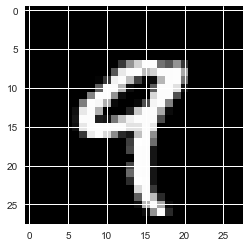

tensor([[1.5483e-03, 6.3488e-04, 5.3132e-04, 2.0260e-03, 4.4799e-02, 4.3634e-03,
         6.9272e-05, 3.9551e-02, 1.1885e-02, 8.2298e-01]],
       grad_fn=<ExpBackward>)


In [10]:
dataloader_iterator = iter(test_loader)
print(len(test_loader.dataset))
x, y = next(dataloader_iterator)
i = 4
# y = F.one_hot(y, num_classes=10).float()
print(y[i])
img = x[i].view(28, 28).data

plt.figure()
plt.imshow(img, cmap='gray')
plt.show()  

z, y_pred = model(x[i].unsqueeze(0))
print(y_pred)

In [38]:
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      z, output = model(data)
      test_loss += 0 #F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
#   test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
test()

60000
tensor(9)


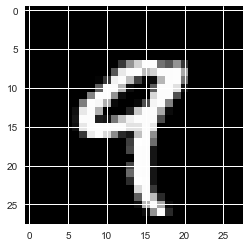

tensor([[9.7070e-04, 2.4392e-04, 4.1119e-04, 1.5993e-03, 2.8569e-02, 2.1421e-03,
         3.5625e-05, 2.4914e-02, 1.1930e-02, 9.0309e-01]],
       grad_fn=<ExpBackward>)


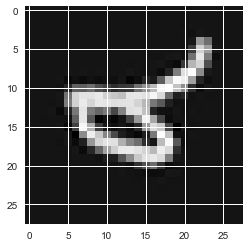

tensor([[0.0044, 0.0036, 0.0029, 0.0481, 0.0248, 0.5078, 0.0315, 0.0016, 0.0805,
         0.0250]], grad_fn=<ExpBackward>)


In [36]:
dataloader_iterator = iter(test_loader)
print(len(test_loader.dataset))
x, y = next(dataloader_iterator)
i = 4
print(y[i])
img = x[i].view(28, 28).data

plt.figure()
plt.imshow(img, cmap='gray')
plt.show()  

z, y_pred = model(x[i].unsqueeze(0))
print(y_pred)

def rotate_img(x, deg):
    import scipy.ndimage as nd
    return nd.rotate(x.reshape(28,28),deg,reshape=False).ravel()

rotated = rotate_img(img, 120).reshape(28, 28)

plt.figure()
plt.imshow(rotated, cmap='gray')
plt.show()  

z, y_pred = model(torch.from_numpy(rotated.reshape(1, 1, 28, 28)))
print(y_pred)

In [37]:
print(model)

CNN_DUQ(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
)
